In [1]:
from cartopy import config
import cartopy.crs as ccrs
import matplotlib.colors as plt_cols

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import time, json, requests, pprint, copy, math, dateutil
from datetime import datetime, timedelta
from argovisHelpers import helpers as avh

import os

In [2]:
API_KEY=''

API_PREFIX_all = 'https://argovis-api.colorado.edu/'
API_PREFIX_drifters = 'https://argovisbeta01.colorado.edu/dapi/'

In [3]:
#fpath = os.path.expanduser('~/Downloads/')
fpath = '../'

In [4]:
# startDate = '2019-08-13T00:00:00Z'
# endDate = '2019-08-31T00:00:00Z'

startDate = '2015-01-01T00:00:00Z'
endDate   = '2017-01-01T00:00:00Z'

# startDate = '2000-01-01T00:00:00Z'
# endDate = '2023-03-01T00:00:00Z'


dx = 1
dy = 1

x_edges = np.arange(-180,181,dx)
y_edges = np.arange(-90,91,dy)



In [5]:
# argo = requests.get(url,headers=headers).json()

In [6]:
def map_count_in_bins(name,x_edges,y_edges,dx,dy,fpath,startDate,endDate,vmin_map=1,vmax_map=1000):
    d = globals()[name] 
    lons = d['longitudes']#[x[1] for x in d]
    lats  = d['latitudes']#[x[2] for x in d]
    datetimes  = d['datetimes'] #[datetime.strptime(x[3][0:18]+'Z',"%Y-%m-%dT%H:%M:%SZ") for x in d]
    
    fig = plt.figure(figsize=(21, 7))
    
    h = np.histogram2d(lons, lats,[x_edges, y_edges])
    ax = plt.axes(projection=ccrs.PlateCarree())

    plt.pcolormesh(x_edges[0:-1]+dx/2, y_edges[0:-1]+dy/2, h[0].transpose(),  #60,
             transform=ccrs.PlateCarree(),norm=plt_cols.LogNorm(),vmin=vmin_map,vmax=vmax_map)

    ax.stock_img()
    ax.coastlines()
    
    plt.colorbar()

    plt.savefig(fpath+name+startDate[0:10]+'_'+endDate[0:10]+'.png')
    plt.show()

### Number of profiles per bin for different products: query the info and create a map

The info to create the maps is also saved in a .pkl file.

In [7]:
def create_df(mydict_name,api_output):
    bfr = pd.DataFrame(globals()[api_output])
    
    if 'geolocation' in bfr.keys():
        bfr['id'] = bfr.pop('_id')
        bfr['longitudes'] = bfr.pop('geolocation')
        bfr['latitudes'] = bfr['longitudes']
        bfr['longitudes'] = [x['coordinates'][0] for x in bfr['longitudes']]
        bfr['latitudes'] = [x['coordinates'][1] for x in bfr['latitudes']]
        bfr['datetimes'] = bfr.pop('timestamp')
        #if len(bfr.keys()) > 4:
        #    bfr['tags'] = bfr.pop(4)
        #print(bfr)
    else:
        bfr.rename( columns={0 :'id'}, inplace=True )
        bfr.rename( columns={1 :'longitudes'}, inplace=True )
        bfr.rename( columns={2 :'latitudes'}, inplace=True )
        bfr.rename( columns={3 :'datetimes'}, inplace=True )
        bfr.rename( columns={4 :'source'}, inplace=True )
    return bfr

tc
2023-03-24 00:12:05.944605
2023-03-24 00:12:09.874877


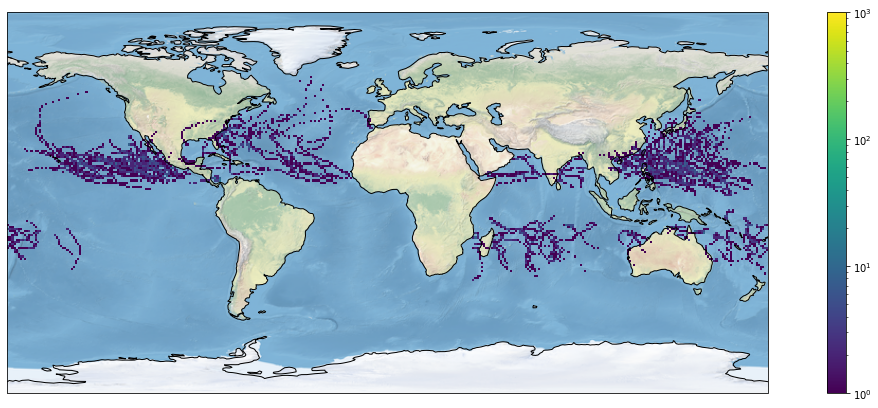

2023-03-24 00:12:11.349983
cchdo
2023-03-24 00:12:11.350176
2023-03-24 00:12:29.713117


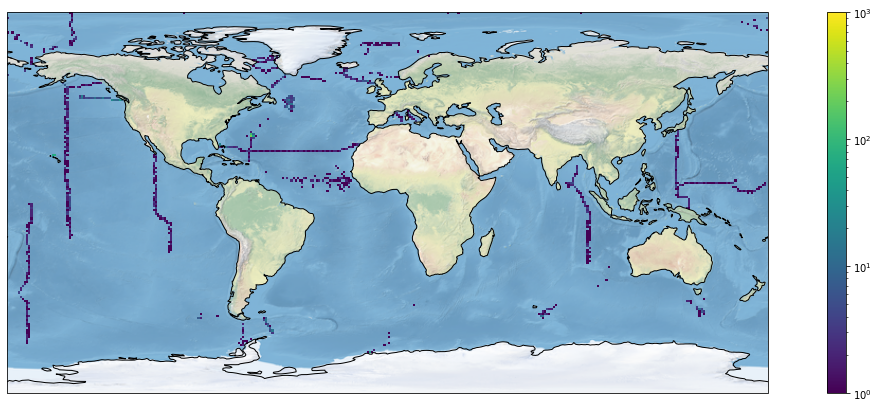

2023-03-24 00:12:30.444880
argo
2023-03-24 00:12:30.444917


In [ ]:
params = {
        'startDate': startDate,
        'endDate': endDate,
        'compression': 'minimal'
    } # 'compression': 'minimal'

for collection in ['tc','cchdo','argo']: #,'drifters'
    print(collection)
    if collection == 'drifters':
        API_PREFIX = API_PREFIX_drifters
    else:
        API_PREFIX = API_PREFIX_all
    print(datetime.now())
    globals()[collection] = avh.query(collection, options=params, apikey=API_KEY, apiroot=API_PREFIX)
    print(datetime.now())
    # create dataframe with columns of interest
    mydict_name = 'df_'+collection
    globals()[mydict_name] = create_df(mydict_name=mydict_name,api_output=collection)
    
    # save info to .pkl file
    output = open(fpath+mydict_name+'_'+startDate[0:10]+'_'+endDate[0:10]+'.pkl', 'wb')
    pickle.dump(globals()[mydict_name], output)
    output.close()
    
    # plot map with count at each bin
    map_count_in_bins(name=mydict_name,x_edges=x_edges,y_edges=y_edges,dx=dx,dy=dy, \
                      fpath=fpath,startDate=startDate,endDate=endDate,vmin_map=1,vmax_map=1000)
    print(datetime.now())
    
# longitudes = [x['geolocation']['coordinates'][0] for x in d]
# latitudes  = [x['geolocation']['coordinates'][1] for x in d]

### Info saved in the .pkl files (in the previous cell) is used to create the maps again

In [ ]:
for name in ['df_argo','df_cchdo','df_tc']: # ['df_tc','df_argo','df_cchdo','df_drifters']:
    if name not in globals():
        globals()[name] = pickle.load( open( fpath+name+'_'+startDate[0:10]+'_'+endDate[0:10]+'.pkl', "rb" ) )
    map_count_in_bins(name=name,x_edges=x_edges,y_edges=y_edges,dx=dx,dy=dy, \
                      fpath=fpath,startDate=startDate,endDate=endDate,vmin_map=1,vmax_map=1000)
        

#### Let's plot maps for e.g. only argo_core, argo_bgc, argo_deep, and profiles that are both bgc and deep

In [ ]:
argo_core_only = ['argo_bgc' not in x and 'argo_deep' not in x for x in df_argo['source']]
sum(argo_core_only)


In [ ]:
argo_bgc_only  = ['argo_bgc' in x and 'argo_deep' not in x for x in df_argo['source']]
sum(argo_bgc_only)


In [ ]:
argo_deep_only  = ['argo_bgc' not in x and 'argo_deep' in x for x in df_argo['source']]
sum(argo_deep_only)


In [ ]:
argo_bgc_and_deep  = ['argo_bgc' in x and 'argo_deep' in x for x in df_argo['source']]
sum(argo_bgc_and_deep)

In [ ]:
len(df_argo['source'])==sum(argo_core_only)+sum(argo_bgc_only)+sum(argo_deep_only)+sum(argo_bgc_and_deep)

In [ ]:
# df_argo = pickle.load( open( fpath+"df_argo.pkl", "rb" ) )

In [ ]:
df_argo_core_only = df_argo[argo_core_only].reset_index()
len(df_argo_core_only)


In [ ]:
df_argo_bgc_all = df_argo[[a or b for a, b in zip(argo_bgc_only, argo_bgc_and_deep)]].reset_index()
len(df_argo_bgc_all)


In [ ]:
df_argo_deep_all = df_argo[[a or b for a, b in zip(argo_deep_only, argo_bgc_and_deep)]].reset_index()
len(df_argo_deep_all)


In [ ]:
df_argo_bgc_and_deep = df_argo[argo_bgc_and_deep].reset_index()
len(df_argo_bgc_and_deep)


In [ ]:
for name in ['df_argo_core_only','df_argo_bgc_all','df_argo_deep_all','df_argo_bgc_and_deep']: # ['df_tc','df_argo','df_cchdo','df_drifters']:
    map_count_in_bins(name=name,x_edges=x_edges,y_edges=y_edges,dx=dx,dy=dy, \
                      fpath=fpath,startDate=startDate,endDate=endDate,vmin_map=1,vmax_map=1000)

### Plot number of profiles each year for Argo core, bgc, deep

Create timeseries of years for each argo source

In [ ]:
for name in ['df_argo','df_argo_core_only','df_argo_bgc_all','df_argo_deep_all','df_argo_bgc_and_deep']: 
    bfr = globals()[name]
    globals()[name+'_datetime']   = pd.to_datetime([np.datetime64(x[0:4]+'-'+x[5:7]+'-'+x[8:10]) for x in bfr['datetimes']])
    
    

In [ ]:
years_bins = np.unique(df_argo_datetime.year)-.5
years_bins = np.append(years_bins,max(np.unique(years_bins))+1)

for name in ['df_argo','df_argo_core_only','df_argo_bgc_all','df_argo_deep_all','df_argo_bgc_and_deep']: 
    bfr_datetime = globals()[name+'_datetime']
    bfr_year     = bfr_datetime.year
    globals()[name+'_years_hist'] = plt.hist(bfr_year, bins=years_bins)
    

In [ ]:
#species = ("Adelie", "Chinstrap", "Gentoo")
# penguin_means

argo_tags = {
    'Core': df_argo_years_hist[0],
    'BGC': df_argo_bgc_all_years_hist[0],
    'Deep': df_argo_deep_all_years_hist[0],
} # 

argo_tags_cols = ['k', 'g', 'r']

x = years_bins[0:-1]+0.5  # the label locations
width = 0.3  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(28, 7),layout='constrained')

n = 0
for attribute, measurement in argo_tags.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute,color=argo_tags_cols[n])
    ax.bar_label(rects, padding=5, size=18, rotation=90,color=argo_tags_cols[n],fontweight='bold')
    multiplier += 1
    n = n + 1
    
# Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
ax.set_title('Number of Argo profiles by year',size=40)
ax.tick_params(axis='both', labelsize=40)
#ax.set_xticks(x + width, species)
# ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 250000)
ax.set_xlabel('Year',size=40)

plt.show()

### Plots for profiles that include e.g. oxygen

In [ ]:
tag_select = '_select_byData_byPres'

params = {
        'startDate': startDate,
        'endDate': endDate,
        'data': 'doxy,except-data-values',
        'presRange': '80,100',
        'compression': 'minimal'
    } # 'compression': 'minimal'

for collection in ['argo']: #,'drifters'
    print(collection)
    if collection == 'drifters':
        API_PREFIX = API_PREFIX_drifters
    else:
        API_PREFIX = API_PREFIX_all
    print(datetime.now())
    globals()[collection] = avh.query(collection, options=params, apikey=API_KEY, apiroot=API_PREFIX)
    print(datetime.now())
    # create dataframe with columns of interest
    mydict_name = 'df_'+collection+tag_select
    globals()[mydict_name] = create_df(mydict_name=mydict_name,api_output=collection)
    
    # save info to .pkl file
    output = open(fpath+mydict_name+'_'+startDate[0:10]+'_'+endDate[0:10]+'.pkl', 'wb')
    pickle.dump(globals()[mydict_name], output)
    output.close()
    
    # plot map with count at each bin
    map_count_in_bins(name=mydict_name,x_edges=x_edges,y_edges=y_edges,dx=dx,dy=dy, \
                      fpath=fpath,startDate=startDate,endDate=endDate,vmin_map=1,vmax_map=1000)
    print(datetime.now())

In [ ]:
df_argo_select_byData_byPres_datetime = pd.to_datetime([np.datetime64(x[0:4]+'-'+x[5:7]+'-'+x[8:10]) for x in df_argo_select_byData_byPres['datetimes']])
df_argo_select_byData_byPres_datetime.year


In [ ]:
bfr_hist = plt.hist(df_argo_select_byData_byPres_datetime.year, bins=years_bins)
plt.close()
fig, ax = plt.subplots(figsize=(20, 10),layout='constrained')
rects = ax.bar(years_bins[0:-1]+0.5, bfr_hist[0], width,color='g')
ax.bar_label(rects, padding=5, size=18, rotation=90,color='g',fontweight='bold')
ax.set_title('Number of Argo profiles that include doxy, by year',size=40)
ax.tick_params(axis='both', labelsize=40)
#ax.set_xticks(x + width, species)
# ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 30000)
ax.set_xlabel('Year',size=40)
